#SIS202560 - Procesamiento Inteligente de Datos
## Otoño 2025

</div>

### SIS202560_MirandaHau-Python

* SIS202560_Python_MirandaHau_Tarea-2
* Ejercicio Unidad 2
* 2.Problema de clasificación

**Datos del estudiante:**
* Nombre completo: Deysi Miranda Hau Marrufo
* Mátricula: 00443416


Profesor: Enrique Naredo García

#Ejercicio Unidad 2

##2. Problema de clasificación

##**Introducción**

**Objetivo general:** Desarrollar y evaluar un modelo de regresión logística que resuelva un problema de clasificación multiclase, comparando enfoques (multinomial vs uno-contra-resto), explorando la regularización y realizando un análisis de clusters exploratorio.

**Puntos clave del trabajo:**
- Generar datos sintéticos con `make_classification` (2000 muestras, 15 características: 10 informativas, 5 redundantes, 5 clases).
- Entrenar y comparar un modelo de **regresión logística multinomial (softmax)** y un **modelo OvR (one-vs-rest)**.
- Realizar un **análisis de regularización** variando el hiperparámetro C (penalización l2; opción l1 con `saga`).
- Evaluar con **matriz de confusión**, **classification report**, **ROC/AUC (micro y por clase)**.
- Realizar un **análisis de clusters** (K-Means) con reducción PCA para exploración y comparación con métricas ARI y NMI.

## **Código Python**

En esta sección se ecuentra el código dividido en celdas coherentes. Cada celda contiene comentarios y una breve explicación previa para posteriormente ejecutar las celdas en orden.

In [1]:
# ---------- Imports y generación de datos ----------
import numpy as np
import matplotlib.pyplot as plt

from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, label_binarize
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import (accuracy_score, classification_report, confusion_matrix,
                             roc_curve, auc)
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score

# Configuración reproducible
np.random.seed(42)
semilla = 42

# Parámetros solicitados
n_muestras = 2000
n_caracteristicas = 15
n_informativas = 10
n_redundantes = 5
n_clases = 5

# Generación de datos sintéticos
X, y = make_classification(
    n_samples=n_muestras,
    n_features=n_caracteristicas,
    n_informative=n_informativas,
    n_redundant=n_redundantes,
    n_classes=n_clases,
    random_state=semilla
)

# División entrenamiento / prueba (25% prueba) con estratificación para mantener balance de clases
X_ent, X_pru, y_ent, y_pru = train_test_split(X, y, test_size=0.25, stratify=y, random_state=semilla)

# Estandarización (muy importante para modelos lineales y regularización)
escalador = StandardScaler()
X_ent_esc = escalador.fit_transform(X_ent)
X_pru_esc = escalador.transform(X_pru)

print("Dataset generado:")
print(" - X_ent:", X_ent_esc.shape)
print(" - X_pru:", X_pru_esc.shape)
print(" - Clases:", np.unique(y))

Dataset generado:
 - X_ent: (1500, 15)
 - X_pru: (500, 15)
 - Clases: [0 1 2 3 4]


### Regresión logística multinomial (softmax)

Explicación: Entrenamos un modelo con `multi_class='multinomial'` y `solver='lbfgs'` (recomendado para el caso con l2). Evaluamos exactitud, reporte por clase y matriz de confusión.

/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Exactitud (multinomial): 0.5960

Reporte de clasificación (multinomial):
              precision    recall  f1-score   support

           0     0.5283    0.5657    0.5463        99
           1     0.7200    0.7200    0.7200       100
           2     0.6224    0.6100    0.6162       100
           3     0.5510    0.5347    0.5427       101
           4     0.5612    0.5500    0.5556       100

    accuracy                         0.5960       500
   macro avg     0.5966    0.5961    0.5962       500
weighted avg     0.5966    0.5960    0.5961       500

Matriz de confusión (multinomial):
 [[56  2  8 16 17]
 [ 0 72  8  4 16]
 [ 7 11 61 13  8]
 [30  8  7 54  2]
 [13  7 14 11 55]]


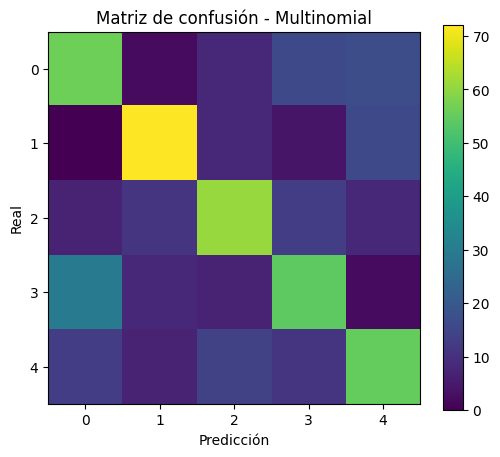

In [2]:
# ---------- Modelo multinomial ----------
modelo_multinomial = LogisticRegression(multi_class='multinomial', solver='lbfgs', C=1.0, max_iter=1000)
modelo_multinomial.fit(X_ent_esc, y_ent)

# Predicción y métricas
y_pred_mult = modelo_multinomial.predict(X_pru_esc)
acc_mult = accuracy_score(y_pru, y_pred_mult)

print(f"Exactitud (multinomial): {acc_mult:.4f}\n")
print("Reporte de clasificación (multinomial):")
print(classification_report(y_pru, y_pred_mult, digits=4))

mat_conf_mult = confusion_matrix(y_pru, y_pred_mult)
print("Matriz de confusión (multinomial):\n", mat_conf_mult)

# Visualización de la matriz de confusión
plt.figure(figsize=(6,5))
plt.imshow(mat_conf_mult, interpolation='nearest')
plt.title("Matriz de confusión - Multinomial")
plt.xlabel("Predicción")
plt.ylabel("Real")
plt.colorbar()
plt.show()

### Clasificación Uno-contra-Resto (OvR)

Explicación: Usameos el mismo algoritmo pero con `multi_class='ovr'`. Se entrena un clasificador por clase vs las restantes. Comparamos su desempeño con el enfoque multinomial.

/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


Exactitud (OvR): 0.5900

Reporte de clasificación (OvR):
              precision    recall  f1-score   support

           0     0.5185    0.5657    0.5411        99
           1     0.7115    0.7400    0.7255       100
           2     0.6000    0.6000    0.6000       100
           3     0.5426    0.5050    0.5231       101
           4     0.5745    0.5400    0.5567       100

    accuracy                         0.5900       500
   macro avg     0.5894    0.5901    0.5893       500
weighted avg     0.5895    0.5900    0.5892       500

Matriz de confusión (OvR):
 [[56  2  9 17 15]
 [ 0 74  8  3 15]
 [ 6 11 60 15  8]
 [31  9  8 51  2]
 [15  8 15  8 54]]


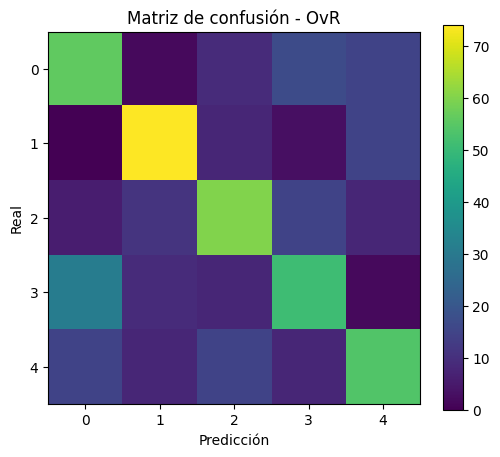

In [3]:
# ---------- Modelo OvR ----------
modelo_ovr = LogisticRegression(multi_class='ovr', solver='lbfgs', C=1.0, max_iter=1000)
modelo_ovr.fit(X_ent_esc, y_ent)

y_pred_ovr = modelo_ovr.predict(X_pru_esc)
acc_ovr = accuracy_score(y_pru, y_pred_ovr)

print(f"Exactitud (OvR): {acc_ovr:.4f}\n")
print("Reporte de clasificación (OvR):")
print(classification_report(y_pru, y_pred_ovr, digits=4))

mat_conf_ovr = confusion_matrix(y_pru, y_pred_ovr)
print("Matriz de confusión (OvR):\n", mat_conf_ovr)

plt.figure(figsize=(6,5))
plt.imshow(mat_conf_ovr, interpolation='nearest')
plt.title("Matriz de confusión - OvR")
plt.xlabel("Predicción")
plt.ylabel("Real")
plt.colorbar()
plt.show()

### Regularización

Explicación: Ahora probaremos varios valores de C para observar el efecto de la regularización (l2). `C` pequeño → regularización fuerte. Graficaremos exactitud en prueba vs C (escala log).

/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1

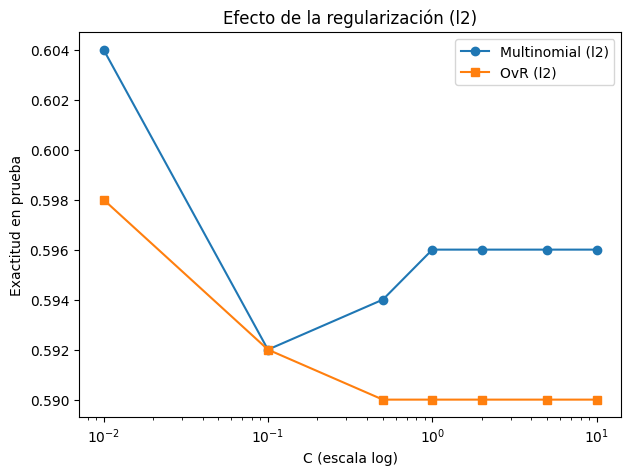

C=0.01   Multinomial=0.6040  OvR=0.5980
C=0.1    Multinomial=0.5920  OvR=0.5920
C=0.5    Multinomial=0.5940  OvR=0.5900
C=1.0    Multinomial=0.5960  OvR=0.5900
C=2.0    Multinomial=0.5960  OvR=0.5900
C=5.0    Multinomial=0.5960  OvR=0.5900
C=10.0   Multinomial=0.5960  OvR=0.5900


In [4]:
# ---------- Barrido del hiperparámetro C ----------
valores_C = [0.01, 0.1, 0.5, 1.0, 2.0, 5.0, 10.0]
acc_mult_lista = []
acc_ovr_lista = []

for C in valores_C:
    m_mult = LogisticRegression(multi_class='multinomial', solver='lbfgs', C=C, max_iter=1000)
    m_mult.fit(X_ent_esc, y_ent)
    acc_mult_lista.append(accuracy_score(y_pru, m_mult.predict(X_pru_esc)))

    m_ovr = LogisticRegression(multi_class='ovr', solver='lbfgs', C=C, max_iter=1000)
    m_ovr.fit(X_ent_esc, y_ent)
    acc_ovr_lista.append(accuracy_score(y_pru, m_ovr.predict(X_pru_esc)))

# Gráfico
plt.figure(figsize=(7,5))
plt.plot(valores_C, acc_mult_lista, marker='o', label='Multinomial (l2)')
plt.plot(valores_C, acc_ovr_lista, marker='s', label='OvR (l2)')
plt.xscale('log')
plt.xlabel('C (escala log)')
plt.ylabel('Exactitud en prueba')
plt.title('Efecto de la regularización (l2)')
plt.legend()
plt.show()

# Imprimir resultados
for C, a1, a2 in zip(valores_C, acc_mult_lista, acc_ovr_lista):
    print(f"C={C:<5}  Multinomial={a1:.4f}  OvR={a2:.4f}")

### ROC y AUC en multiclase

Explicación: Para ROC multiclase hacemos binarizado de etiquetas y usamos One-vs-Rest para obtener scores por clase. Calculamos AUC por clase y AUC micro.

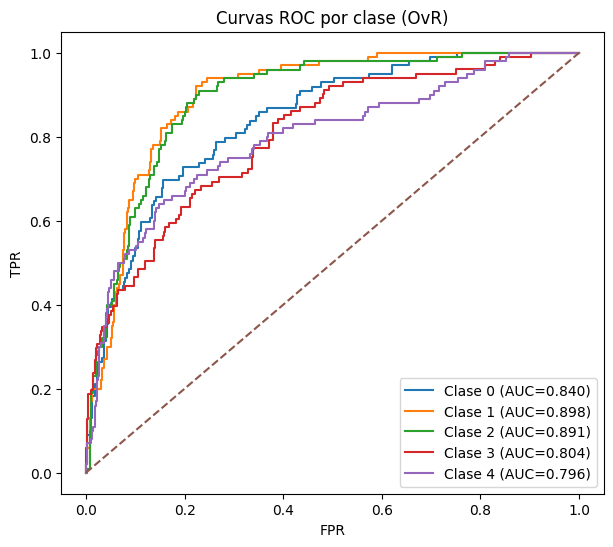

AUC macro promedio: 0.8459
AUC micro: 0.8501


In [5]:
# ---------- ROC/AUC multiclase ----------
# Binarizar etiquetas
clases_unicas = np.unique(y)
y_pru_bin = label_binarize(y_pru, classes=clases_unicas)
n_clases = y_pru_bin.shape[1]

# One-vs-Rest para obtener scores
ovr_prob = OneVsRestClassifier(LogisticRegression(solver='lbfgs', max_iter=1000))
ovr_prob.fit(X_ent_esc, y_ent)
# decision_function puede devolver scores; para algunos solvers predict_proba también está disponible
try:
    y_score = ovr_prob.decision_function(X_pru_esc)
except:
    y_score = ovr_prob.predict_proba(X_pru_esc)

fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_clases):
    fpr[i], tpr[i], _ = roc_curve(y_pru_bin[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# AUC micro
fpr_micro, tpr_micro, _ = roc_curve(y_pru_bin.ravel(), y_score.ravel())
roc_auc_micro = auc(fpr_micro, tpr_micro)
roc_auc_macro = np.mean(list(roc_auc.values()))

# Gráficas por clase
plt.figure(figsize=(7,6))
for i in range(n_clases):
    plt.plot(fpr[i], tpr[i], label=f"Clase {i} (AUC={roc_auc[i]:.3f})")
plt.plot([0,1],[0,1],"--")
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("Curvas ROC por clase (OvR)")
plt.legend()
plt.show()

print(f"AUC macro promedio: {roc_auc_macro:.4f}")
print(f"AUC micro: {roc_auc_micro:.4f}")

### Análisis de clusters (exploratorio)

Explicación: Aplicamos PCA a 2 dimensiones para visualizar y ejecutar K-Means (k=5). Luego comparamos los clusters con las etiquetas reales usando ARI y NMI (métricas de concordancia).

ARI (KMeans vs clases reales): 0.0420
NMI (KMeans vs clases reales): 0.0769


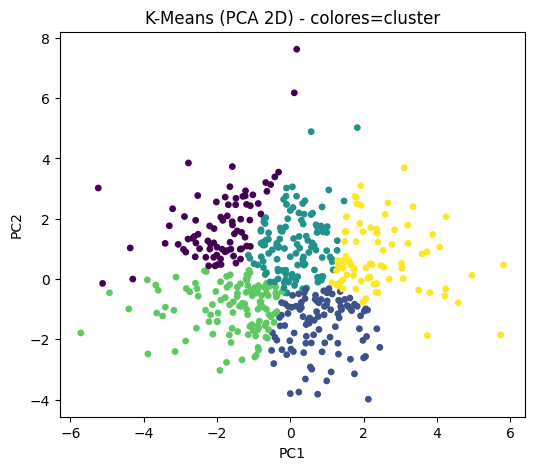

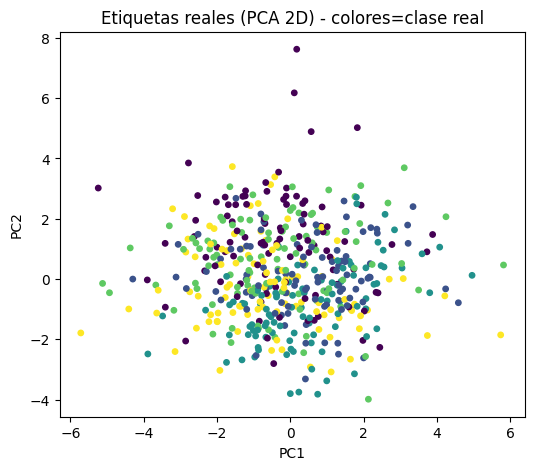

In [6]:
# ---------- PCA para visualización y KMeans ----------
pca = PCA(n_components=2, random_state=semilla)
X_ent_2d = pca.fit_transform(X_ent_esc)
X_pru_2d = pca.transform(X_pru_esc)

kmeans = KMeans(n_clusters=5, n_init=10, random_state=semilla)
kmeans.fit(X_ent_2d)
etiquetas_km = kmeans.predict(X_pru_2d)

ari = adjusted_rand_score(y_pru, etiquetas_km)
nmi = normalized_mutual_info_score(y_pru, etiquetas_km)

print(f"ARI (KMeans vs clases reales): {ari:.4f}")
print(f"NMI (KMeans vs clases reales): {nmi:.4f}")

# Visualización
plt.figure(figsize=(6,5))
plt.scatter(X_pru_2d[:,0], X_pru_2d[:,1], c=etiquetas_km, s=15)
plt.title("K-Means (PCA 2D) - colores=cluster")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.show()

plt.figure(figsize=(6,5))
plt.scatter(X_pru_2d[:,0], X_pru_2d[:,1], c=y_pru, s=15)
plt.title("Etiquetas reales (PCA 2D) - colores=clase real")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.show()

## **Conclusiones**

**Resumen:** En este ejercicio se implementó un modelo de regresión logística multiclase (multinomial) y se comparó con un enfoque One-vs-Rest (OvR) para un dataset sintético de 2000 muestras y 5 clases. Además, se exploró el efecto de la regularización (C) sobre el desempeño de los modelos y se realizó un análisis exploratorio no supervisado mediante K-Means y reducción de dimensionalidad con PCA.

*   Ventajas: modelos interpretables, rápidos de entrenar y con control de sobreajuste mediante regularización.

* Limitaciones: fronteras lineales que no capturan relaciones complejas, sensibilidad a escala y posible necesidad de selección de features.

* Recomendaciones: realizar validación cruzada para ajustar hiperparámetros, explorar modelos no lineales y aplicar técnicas de reducción de dimensionalidad o ingeniería de características.

En general, el ejercicio consolidó conocimientos de clasificación multiclase, regularización y análisis exploratorio, mostrando la importancia de interpretar resultados y elegir la técnica adecuada según los datos.



## Referencias

- Brownlee, J. (s. f.). *Multinomial Logistic Regression With Python*. Machine Learning Mastery. Recuperado de https://machinelearningmastery.com/multinomial-logistic-regression-with-python/  
- Pedregosa, F., Varoquaux, G., Gramfort, A., et al. (2011). Scikit-learn: Machine Learning in Python. *Journal of Machine Learning Research, 12*, 2825–2830.  
- Bishop, C. M. (2006). *Pattern Recognition and Machine Learning*. Springer.
- Fawcett, T. (2006). An introduction to ROC analysis. *Pattern Recognition Letters, 27*(8), 861–874.
- Rey, B. (2018). *Beginner’s Guide to Google Colaboratory*. Medium.